# Projet : Implémentation un modèle de scoring (Modélisation et XAI)

### Partie 3 : Classification & Custom Metric

Ce notebook présente la phase de teste des modèles de **classification**. On cherchera à trouver le modèle le plus adapté à notre problèmatique métier.

**Pour cela, on testera 3 algorithmes :**
- Régression Logisitique (baseline)
- Random Forest Classifier
- LightGBM

On comparera entre autre nos résultats via une **custom metric** adaptée au désequilibre du problème. La construction de cette métrique est détaillée plus loin dans le notebook.

Enfin, on cherchera à interpréter notre modèle pour le rendre **"White box"** pour l'utilisateur. On utilisera les librairies `Lime` et `Shap` pour comprendre l'importance des features et séléctioner les features pertinentes pour les visualisations sur notre dashboard.


### Webb-app : Dashboard

Un dashboard a été construit afin de faciliter le travail des conseillers. Ce dashboard doit permettre aux conseillers de visualiser rapidements les informations clients, situer ce client dans un voisinage

Le dashboard est réalisé via Streamlit et a été déployé sur **Google Cloud Platform**, il est visible ici : https://dashboard-credits-ud5gnwagpa-od.a.run.app/

Pour utiliser ce dashboard il est important d'avoir les **ID_client** disponibles dans le readme.txt sur mon github : https://github.com/Louis-bir/dashboard-project-credits.app

## Librairies

In [1]:
# Classic Lib.
import pandas as pd
import numpy as np

# Viz lib.
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import scikitplot as skplt
from scikitplot.metrics import plot_roc

# Classification.
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

# Resampling
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# Quality metrics.
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import f1_score, recall_score, roc_auc_score

# XAI.
import lime
import shap
import lime.lime_tabular

# Others.
import pickle5 as pickle
from collections import Counter

# Import custom functions.
from Utils.utils_modelization import *

## Settings

In [304]:
# Format & option.
sns.set(rc={'figure.figsize':(14,12)})
pd.options.display.max_columns = 150
sns.set_context("notebook", 
                font_scale=1.5, 
                rc={"lines.linewidth": 2.5})

# Style use.
sns.set_style('darkgrid')
plt.style.use('ggplot')

## Data

In [305]:
# Import processed data.
df_train = pd.read_csv("Data/df_train.csv")
df_test = pd.read_csv("Data/df_test.csv")

# Id_clients.
id_train = df_train["SK_ID_CURR"]
id_test = df_test["SK_ID_CURR"]

# Delete ID.
del df_train["SK_ID_CURR"]
del df_test["SK_ID_CURR"]

# Classification

Dans cette partie on testera différent modèle de classification pour voir quel est le plus adapté à notre problème.
Le coeur du problème réside dans le déséquilibre des **TARGET**. On comparera une approche après **under sampling** et **over sampling** (Avec SMOTE).

### On utilisera les métriques suivantes:
- `Accuracy_score` : % d'individu bien classé (c'est la justesse de la prédiction).
- `Precision` : Quelle proportion de classification positive était correct ?
- `Recall` : Quelle proportion de positif ont été correctement identifié ?
- `F1_score` : Synthèse de Precision et Recall
- `AUC` : Aire sous la courbe ROC.
- `Matrice de confusion`
- `ROC Curve`

### Définition d'une métrique "métier"

Dans cette partie, on cherche à créer **une métrique pertinente** concernant notre problématique.
On se place dans un contexte d'une société de crédit qui cherche à **"maximiser"** ses gains. Par exemple, accorder un crédit à quelqu'un ne pouvant pas le rembourser par la suite **(Faux négatif)** est synonyme de perte pour l'entreprise. Au contraire accorder un crédit à un client qui le rembrousera par la suite **(Vrai négatif)** est un gain.

On cherche à `pondérer` les différents cas de figure possibles **(TP, TN, FP, FN)** pour créer en score. Ce score doit prendre en compte l'aspet gain/perte du problème.

En moyenne, le montant des crédits des clients ne pouvant pas être remboursés s'éleve à **557k €**. (Et celui des clients classés 0 à 602k€). En partant du postulat que les taux d'emprunt sont de 2,6%, l'entreprise gagnera **12k€** par client remboursant le crédit.

**On pondère de la manière suivante (en prenant encompte les pertes et gains pour l'entreprise):**
- TP : 0
- TN : +12
- FP : 0
- FN : -557

`(Finalement après test et création de la custom metric, ces poids n'étaient pas adaptés. J'ai donc séléctionné les poids suivant : TN : 2 et FN : -10)`

On calcul ensuite un score normalisé entre 0 et 1 de la manière suivante: **(score - baseline) / (best - baseline)**.
Avec `best` étant le meilleur classifieur possible (on ne se trompe jamais) et `baseline` un classifieur naïf.

# 1) Avec Undersampling

On teste les performances des algos suivant `(LR, RF, LGBM)` sur la dataset déséquilibré.
On précisera **class_weight='balanced'** pour certains algos afin de corriger le problème de déséquilibre des classes.

Résultats sans undersamling (AUC):
- Regression Logistique : 0.744
- Random Forest : 0.723 
- LightGBM : 0.635

Undersampling de 30% de la class majoritaire.

**Inconvénient de cet undersampling aléatoire :**

Le principal inconvénient du sous-échantillonnage aléatoire est que cette méthode peut écarter des données potentiellement utiles qui pourraient être importantes pour le processus d'apprentissage. La suppression de données est une décision critique à prendre, c'est pourquoi de nombreuses propositions de sous-échantillonnage utilisent des heuristiques afin de surmonter les limites des décisions non heuristiques.


In [307]:
# Split in training, validation testing set.
X_train, y_train = df_train.iloc[:, df_train.columns != "TARGET"], df_train.TARGET
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
X_test, y_test = df_test.iloc[:, df_train.columns != "TARGET"], df_test.TARGET

In [114]:
# Undersampling.
print("Before undersampling count: {}".format(sorted(Counter(y_train).items())))

# After undersampling.
undersample = NearMiss(version=1, n_neighbors=4, sampling_strategy=0.20)
X_train, y_train = undersample.fit_resample(X_train, y_train)
print("After undersampling count: {}".format(sorted(Counter(y_train).items())))

Before undersampling count: [(0, 70986), (1, 6274)]
After undersampling count: [(0, 31370), (1, 6274)]


## A first baseline: Logistic Regression

In [115]:
# Define LR and params.
log_reg = LogisticRegression(max_iter=1000, solver='saga')
params = {'C' : np.logspace(-2, 2, 4)}

# Gridsearch & Crossvalidation.
grid_search_lr_undersampled = GridSearchCV(log_reg, params, cv=5, n_jobs=-1)

# Fit sur les données d'entrainement.
grid_search_lr_undersampled.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/python_projects/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/python_projects/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/python_projects/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/python_projects/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/python_projects/lib/python3.9/site-packages/sklearn/linear_model/_sag

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, solver='saga'),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 2.15443469e-01, 4.64158883e+00, 1.00000000e+02])})

In [116]:
# Probabilité d'appartenance à la classe 1 (positif).
y_prob_lr_u = grid_search_lr_undersampled.best_estimator_.predict_proba(X_validation)[:,1]

# Prédiciton.
y_pred_lr_u = grid_search_lr_undersampled.best_estimator_.predict(X_validation)

### Mesures de qualité

In [117]:
# Matrice de confusion.
confusion_matrix(y_validation, y_pred_lr_u)

Predicted Negative Predicted Positive
Real Negative         20278 (TN)          3423 (FP)
Real Positive          1622 (FN)           431 (TP)

In [118]:
# Indices de qualité.
quality(y_validation, y_pred_lr_u, y_prob_lr_u)

Accuracy : 0.804
Precision : 0.112
Recall : 0.21
Score F1 : 0.146
AUC score : 0.624


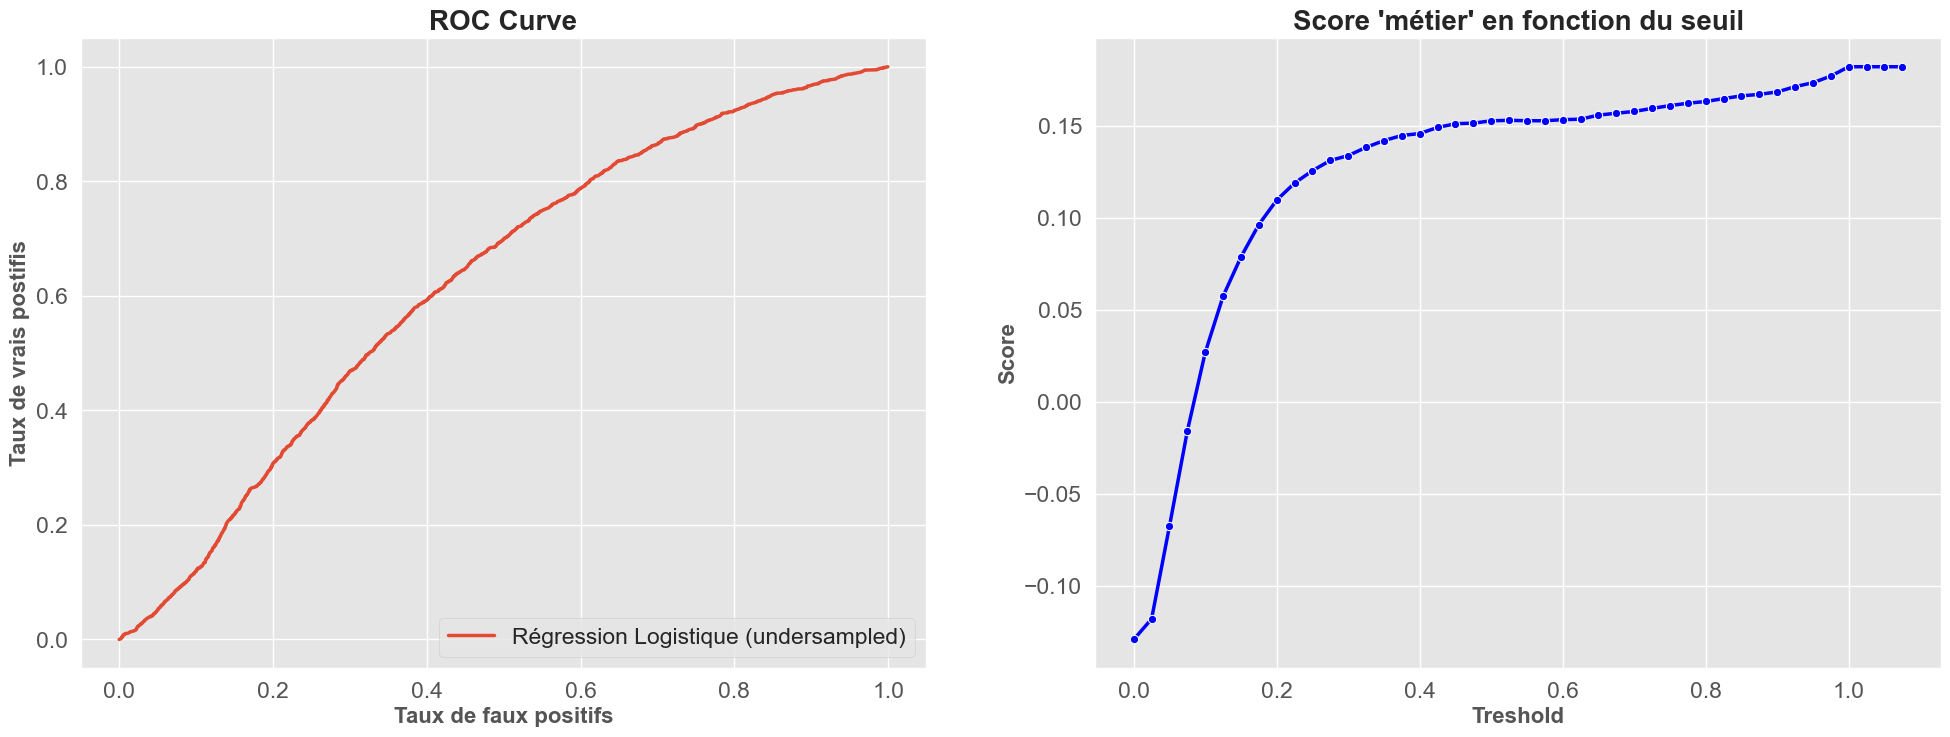

In [126]:
custom_viz(y_validation, y_prob_lr_u, "Régression Logistique (undersampled)")

# RandomForestClassifier

In [127]:
# Random Forest Classifieur.
RF_classifier = RandomForestClassifier(class_weight='balanced')

# GridSearch.
gridSearch_rf_undersampled = GridSearchCV(RF_classifier, 
                                          {'max_depth': range(6,10),
                                           'min_samples_leaf' : [1,2,3]},
                                           scoring='roc_auc',
                                           cv=4)

# Fit sur les données d'entrainement.
gridSearch_rf_undersampled.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'max_depth': range(6, 10),
                         'min_samples_leaf': [1, 2, 3]},
             scoring='roc_auc')

In [128]:
# Prédiction.
y_pred_rf_u = gridSearch_rf_undersampled.best_estimator_.predict(X_validation)

# Proba d'appartenance à la classe 1.
y_prob_rf_u = gridSearch_rf_undersampled.best_estimator_.predict_proba(X_validation)[:,1]

In [129]:
# Matrice de confusion.
confusion_matrix(y_validation, y_pred_rf_u)

Predicted Negative Predicted Positive
Real Negative         17083 (TN)          6618 (FP)
Real Positive           849 (FN)          1204 (TP)

In [130]:
# Indice de qualité.
quality(y_validation, y_pred_rf_u, y_prob_rf_u)

Accuracy : 0.71
Precision : 0.154
Recall : 0.586
Score F1 : 0.244
AUC score : 0.713


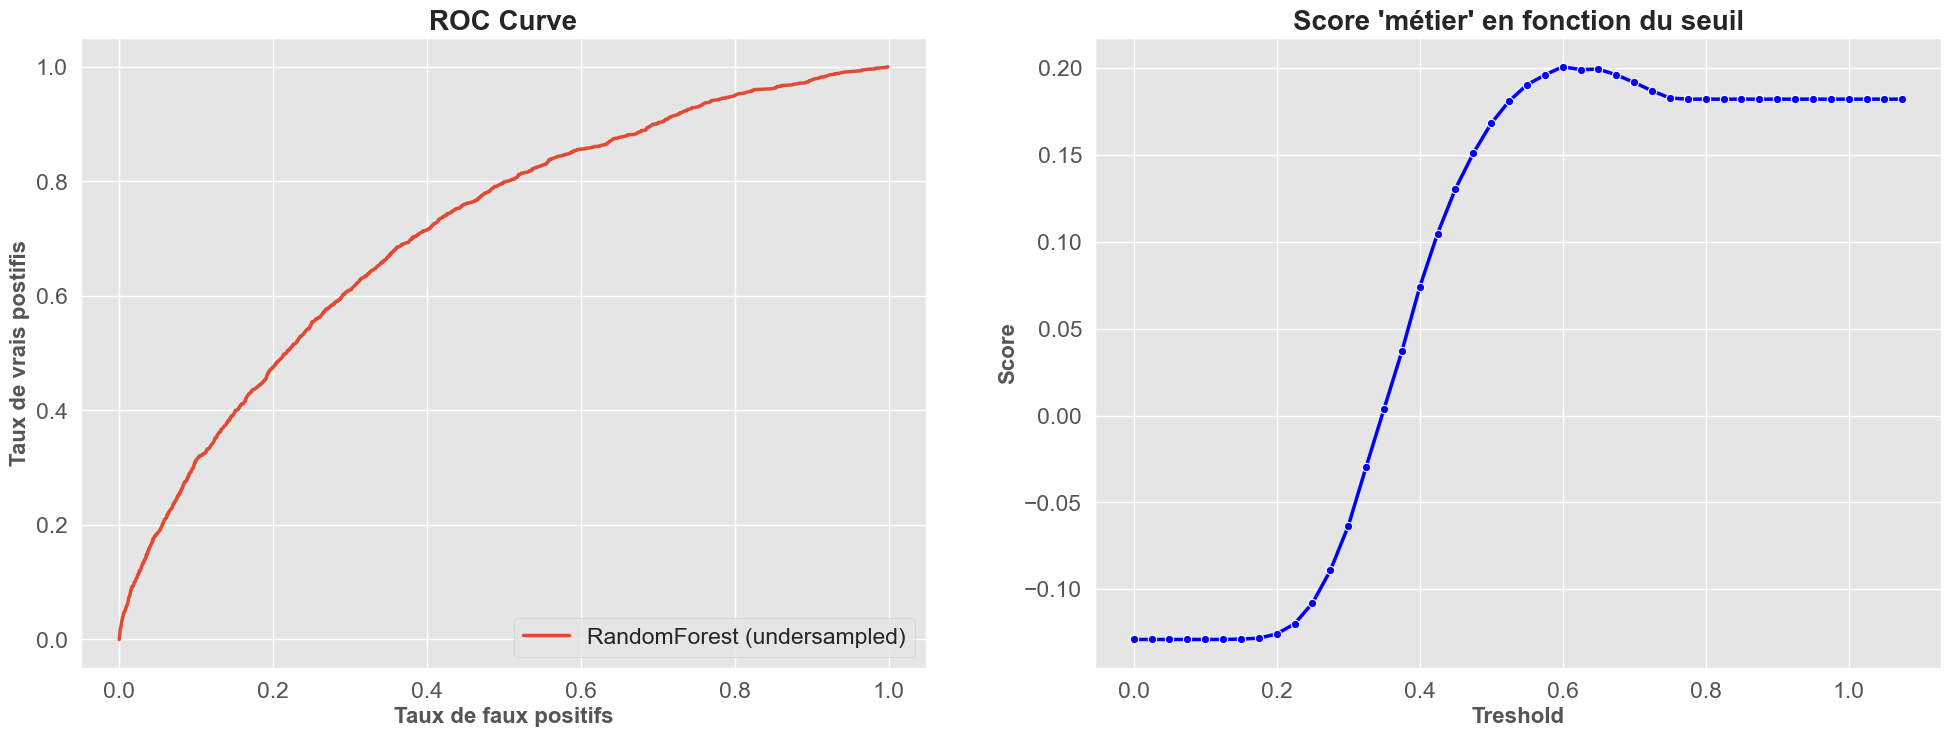

In [131]:
custom_viz(y_validation, y_prob_rf_u, "RandomForest (undersampled)")

# LGBM

In [132]:
# Features names for LGBM.
X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]

In [133]:
# LGBMClassifier.
# On utilise class_weight = 'balanced' de sorte à réduire le pb de déséquilibrage des classes 0 et 1.
lgbm = lgb.LGBMClassifier(objective='binary',
                          num_leaves=34,
                          class_weight='balanced',
                          reg_lambda=0.1, 
                          subsample=0.8,
                          n_jobs=-1)

In [134]:
# Paramètres pour la GridSearch.
params_lbgm = {'n_estimators' : [6000, 8000, 10000],
              'learning_rate' : [1,0.1,0.01]}

# Gridsearch & Crossvalidation.
grid_search_lgbm_undersampled = GridSearchCV(lgbm, params_lbgm, cv=4)

# Fit sur les données d'entrainement.
grid_search_lgbm_undersampled.fit(X_train, y_train,
                                  eval_metric='auc')

GridSearchCV(cv=4,
             estimator=LGBMClassifier(class_weight='balanced', num_leaves=34,
                                      objective='binary', reg_lambda=0.1,
                                      subsample=0.8),
             param_grid={'learning_rate': [1, 0.1, 0.01],
                         'n_estimators': [6000, 8000, 10000]})

In [135]:
# Prediction.
y_pred_lgbm_u = grid_search_lgbm_undersampled.best_estimator_.predict(X_validation)

# Proba prédite.
y_prob__lgbm_u = grid_search_lgbm_undersampled.best_estimator_.predict_proba(X_validation)[:,1]

In [136]:
# Matrice de confusion.
confusion_matrix(y_validation, y_pred_lgbm_u)

Predicted Negative Predicted Positive
Real Negative         23511 (TN)           190 (FP)
Real Positive          1955 (FN)            98 (TP)

In [137]:
quality(y_validation, y_pred_lgbm_u, y_prob__lgbm_u)

Accuracy : 0.917
Precision : 0.34
Recall : 0.048
Score F1 : 0.084
AUC score : 0.696


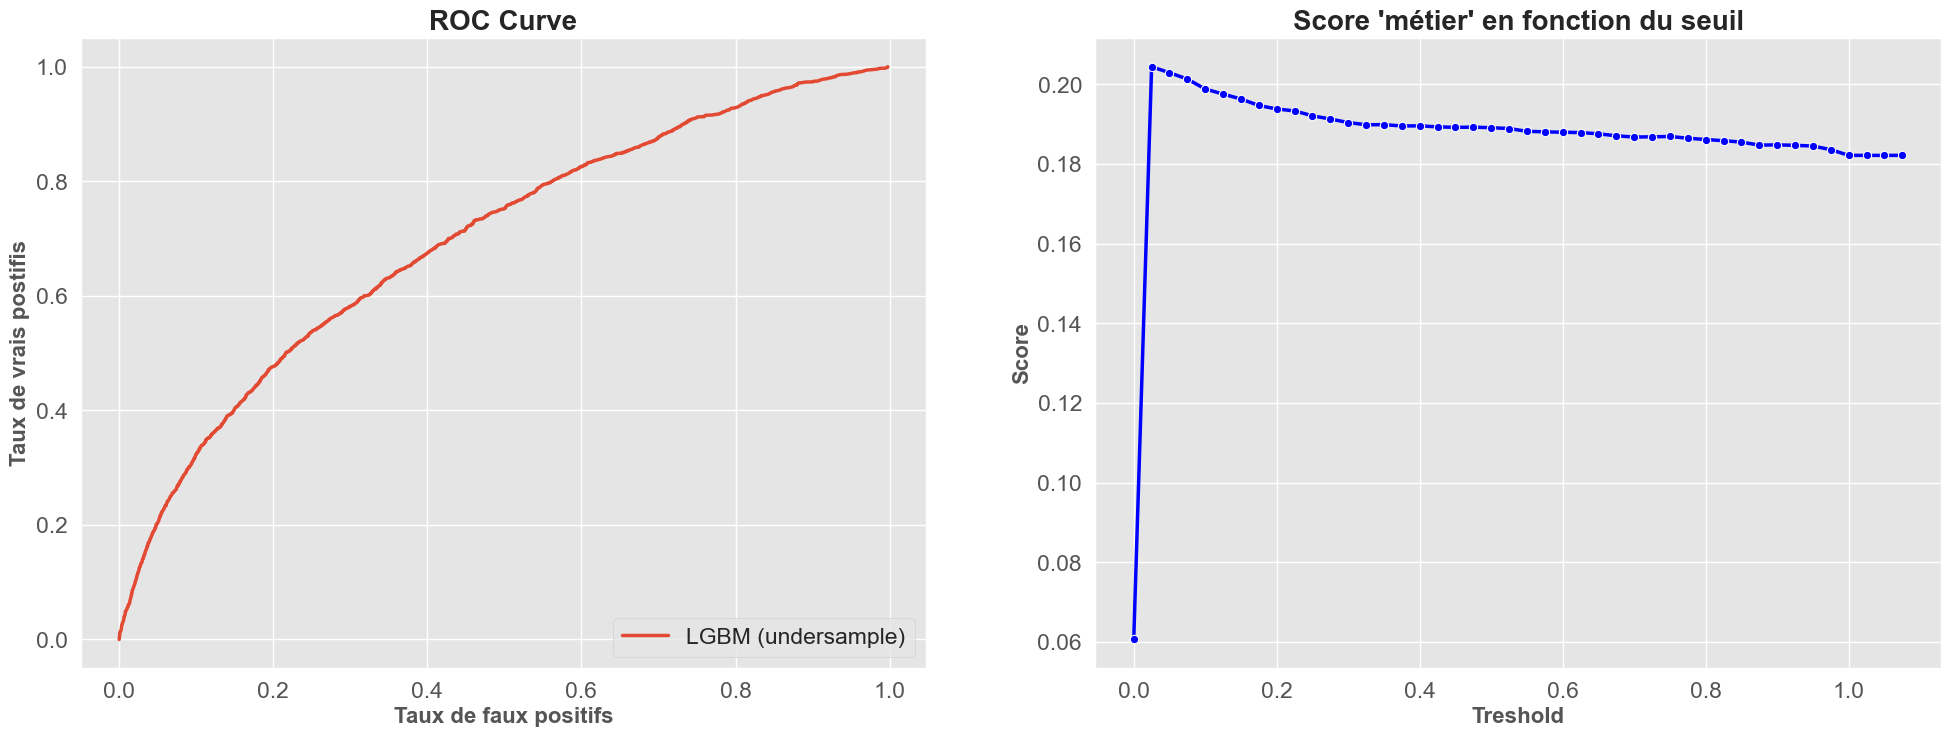

In [138]:
custom_viz(y_validation, y_prob__lgbm_u, "LGBM (undersample)")

# 2) Avec OverSampling  (SMOTE)

**SMOTE** : "Synthetic Minority Oversampling Technique"

Dans cette partie, on séléctionne l'algo nous ayant donnée les meilleurs résultats précédemment **(LGBM)** mais nous essayons une approche d'oversampling pour faire un comparatif.

**L'Oversampling** consiste à venir "doper" la classe minoritaire pour résoudre le problème de déséquilibre. On crée alors des individus artificiels pour équilibrer les classes.
On accordera un soin particulier à oversampler seulement le jeu d'entrainement. 

In [154]:
from Utils.utils_others import *

In [147]:
# Oversampling du jeu d'entrainement.
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

In [148]:
# Check de l'équilibrage des classes sur le jeu d'entrainement.
sorted(Counter(y_train_resampled).items())

[(0, 70986), (1, 70986)]

In [149]:
# LGBMClassifier.
lgbm = lgb.LGBMClassifier(objective='binary', 
                          reg_lambda=0.1, 
                          subsample=0.8,
                          n_jobs=-1)

# Paramètres pour la GridSearch.
params_lbgm = {'n_estimators' : [4000, 5000, 6000],
               'learning_rate' : [1, 0.1, 0.01]}

# Gridsearch & Crossvalidation.
grid_search_lgbm_oversampled = GridSearchCV(lgbm, params_lbgm, cv=4)

# Fit sur les données d'entrainement.
grid_search_lgbm_oversampled.fit(X_train_resampled, 
                                 y_train_resampled,
                                 eval_metric='auc')

GridSearchCV(cv=4,
             estimator=LGBMClassifier(objective='binary', reg_lambda=0.1,
                                      subsample=0.8),
             param_grid={'learning_rate': [1, 0.1, 0.01],
                         'n_estimators': [4000, 5000, 6000]})

In [309]:
pred_resampled = grid_search_lgbm_oversampled.best_estimator_.predict(X_validation)
pred_proba_resampled = grid_search_lgbm_oversampled.best_estimator_.predict_proba(X_validation)[:,1]

In [311]:
# Matrice de confusion.
confusion_matrix(y_validation_, pred_resampled)

Predicted Negative Predicted Positive
Real Negative         22925 (TN)            17 (FP)
Real Positive          1624 (FN)           434 (TP)

In [313]:
quality(y_validation_, pred_resampled, pred_proba_resampled)

Accuracy : 0.934
Precision : 0.962
Recall : 0.211
Score F1 : 0.346
AUC score : 0.916


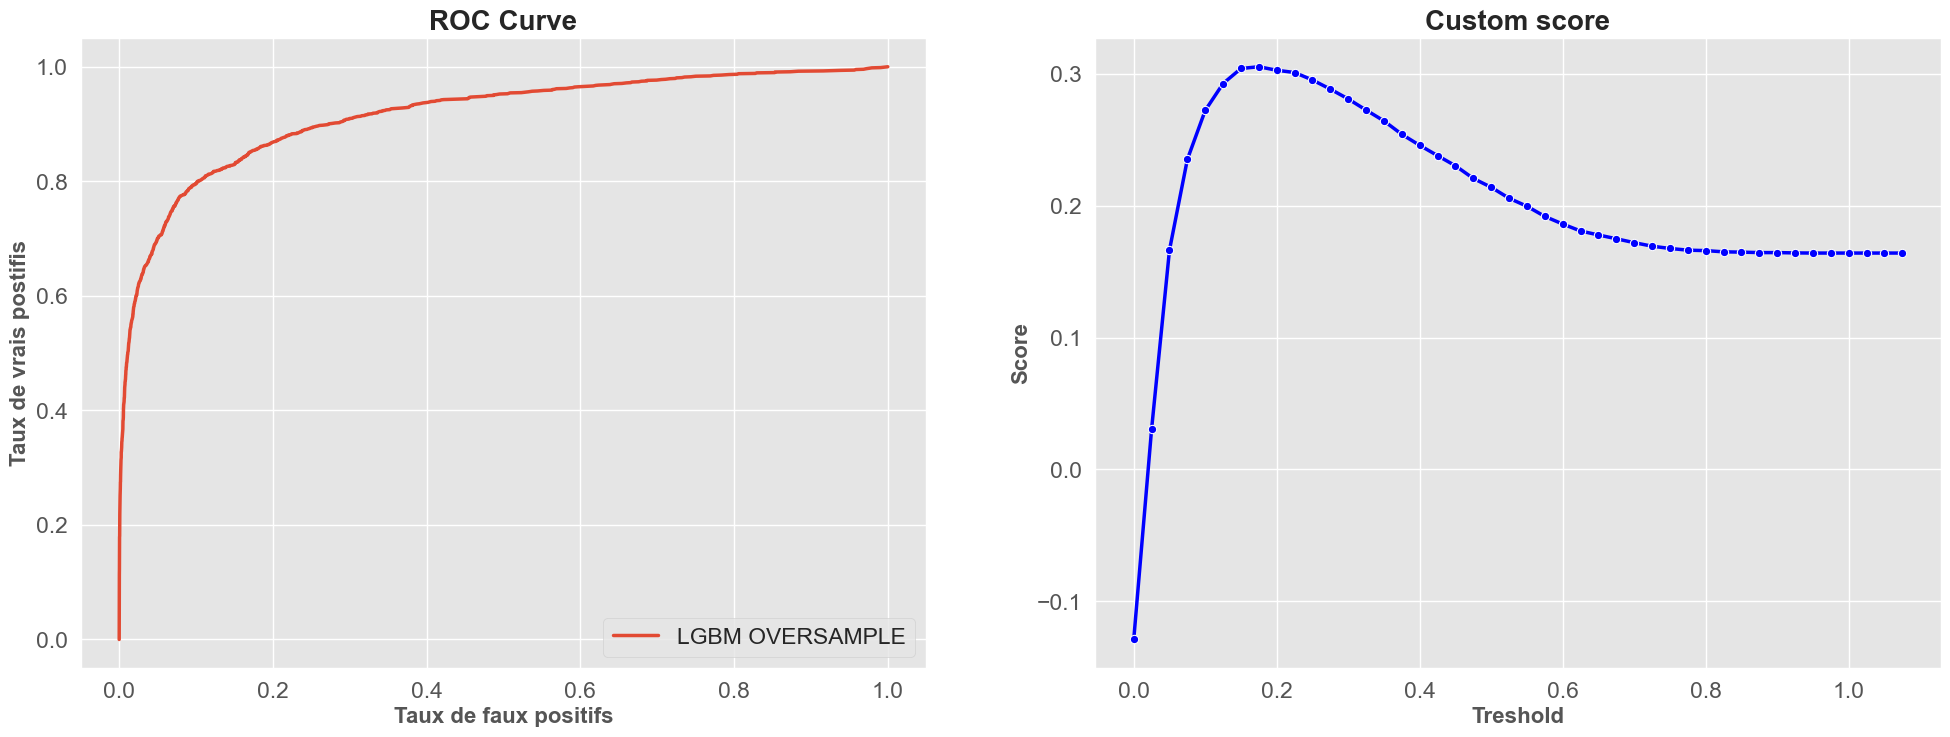

In [320]:
# Best threshold for 0.18
custom_viz(y_validation_, pred_proba_resampled, 'LGBM OVERSAMPLE')

#  Visualisation ROC Curve & Custom metric 

# 1) Custom metric viz

(-0.005, 1.005)

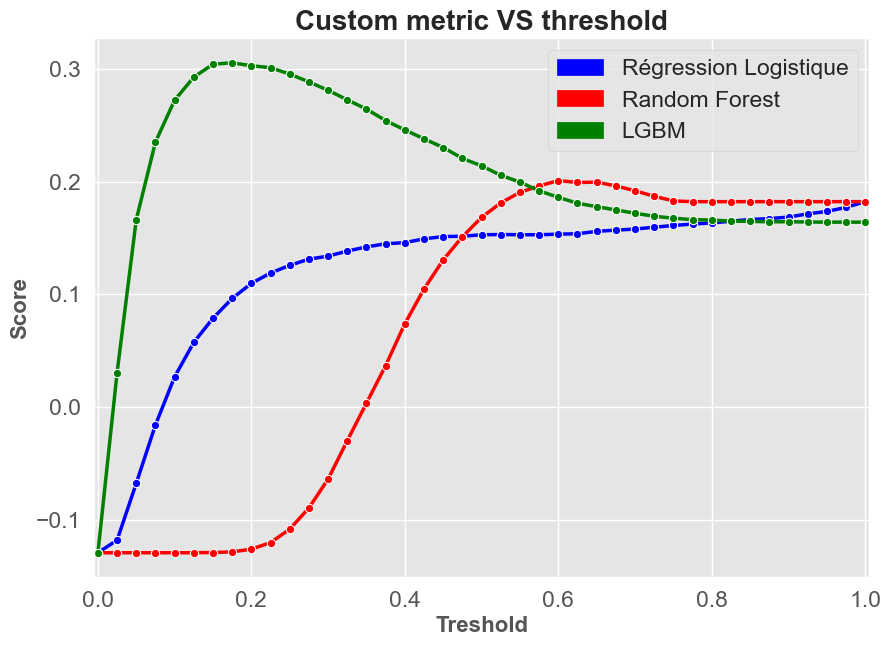

In [330]:
plt.figure(figsize=(10,7))
plt.title("Custom metric VS threshold", weight='bold', size=20)
plt.xlabel('Treshold', size=16, weight='bold')
plt.ylabel('Score', size=16, weight='bold')

# Lineplot.
sns.lineplot(x=np.arange(0.0001,1.1,0.025), y=score_seuil(y_prob_lr_u, y_validation), color = 'blue', marker='o')
sns.lineplot(x=np.arange(0.0001,1.1,0.025), y=score_seuil(y_prob_rf_u, y_validation), color = 'red', marker='o')
sns.lineplot(x=np.arange(0.0001,1.1,0.025), y=score_seuil(pred_proba_resampled, y_validation_), color = 'green', marker='o')

# Légendes.
patch1 = mpatches.Patch(color='blue', label='Régression Logistique')
patch2 = mpatches.Patch(color='red', label='Random Forest')
patch3 = mpatches.Patch(color='green', label='LGBM')
plt.legend(handles=[patch1,patch2,patch3])
plt.xlim([-0.005, 1.005])

# Check final performances on the testing set

- **Algo séléctionné :** LGBM 
- **Treshold séléctionné :** 0.18

In [332]:
# Pred & Proba sur le Test Set.
y_test_prob__lgbm_o = grid_search_lgbm_oversampled.best_estimator_.predict_proba(X_test)[:,1]
y_test_pred__lgbm_o = grid_search_lgbm_oversampled.best_estimator_.predict(X_test)

In [334]:
# Check de la valeur de la custom metric.
custom_metric(y_test, proba_seuil(y_test_prob__lgbm_o, 0.18))

0.449824025192183

In [336]:
quality(y_test, y_test_pred__lgbm_o, y_test_prob__lgbm_o)

Accuracy : 0.739
Precision : 0.149
Recall : 0.478
Score F1 : 0.227
AUC score : 0.679


# Model Explanation with LIME & SHAP

Les modèles les plus performants sont souvent ceux les moins explicables, comment les rendres "white box" ?

Enfin, on cherche à expliquer notre modèle et inspecter l'importance des features.
En effet, cette analyse est cruciale pour nous orienter sur des features qui influencent beaucoup lors de la classification pour notre dashboard.

On utilisera la libraire **LIME** qui utilise le voisinage de l'individus étudié et la libraire **SHAP** qui utilise la théorie des jeux.

## 1) XAI with LIME (Local Interpretable Model-Agnostic Explanations)

-> Explicabilité local (sur une observation)  
-> Model-Agnostic car applicable pour tous les modèles  

In [69]:
X = X_train.values
explainer = lime.lime_tabular.LimeTabularExplainer(X,feature_names=X_train.columns,
                                                   class_names=['Non Défaillant','Défaillant'],
                                                   kernel_width=5)

In [70]:
predict_fn_rf = lambda x: grid_search_lgbm_undersampled.best_estimator_.predict_proba(x).astype(float)

### Individus avec une défaillance de paiement

In [71]:
# Séléction d'un individu du jeu de test étant défaillant.
choosen_instance = X_test.iloc[4086,:]

In [72]:
exp = explainer.explain_instance(choosen_instance, predict_fn_rf,num_features=10)
exp.show_in_notebook(show_all=False)

### Individus n'ayant pas de défaillance de paiement

In [543]:
# Séléction d'un individu du jeu de test étant non défaillant.
choosen_instance = X_test.iloc[36945,:]

In [544]:
exp = explainer.explain_instance(choosen_instance, predict_fn_rf,num_features=10)
exp.show_in_notebook(show_all=False)

## 2) XAI with SHAP

### Théorie des jeux :
- Méthode reposant sur les valeurs de Shapley issues de la Game Theory  
- Théorie des jeux de coallitions  
- Des joueurs peuvent être impliqués plus activement dans la coallition que d'autres. Comment scinder équitablement les gains entre les joueurs lors d'un jeu coopératif ?  
-  Il s'agit d'une méthode visant à redistribuer les bénéfices globaux entre les joueurs, étant donné qu'ils coopèrent tous. (Et à recomposer ceux qui apportent le plus dans les coallitions de manière globale)


### Lien avec le ML et l'explicabilité :
- Les valeurs des features d'une observation sont les membres de la coalition (les joueurs)  
- Les valeurs de Shapley donneront un poids à chaque feature  

<div>
<img src="Images/Shap_values.png" width="400"/>
</div>


### Limites :
- Cette méthode souffre du fléau de la dimension (2^p nombre de coallition possibles)

In [47]:
shap_values = shap.TreeExplainer(grid_search_lgbm_undersampled.best_estimator_).shap_values(X_validation)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


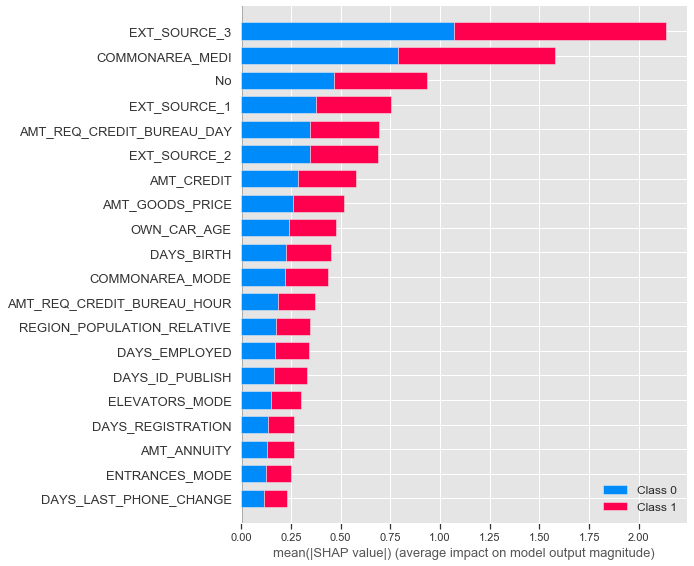

In [48]:
shap.summary_plot(shap_values, X_validation)

In [50]:
# Tree Explainer with SHAP.
explainer = shap.TreeExplainer(grid_search_lgbm_undersampled.best_estimator_)

### Force Plot


- Les features à gauche du plot (en rouge) influence positivement la prédiction (-> 1)
- Les features à droite du plot (en bleu) influence négativement la prédiction (-> 0)
- La "Base value" est la moyenne de tous les outpus sur l'ensemble du training set

In [64]:
# Force plot with SHAP.
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0][0], X_validation.iloc[0,:])